### Preparation

#### 1.1 Import library

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import polars as pl

from src.lib.etl.class_ETL import ETL
from src.lib.frc_model.class_Forecast_Model import Forecast_Model

pd.options.display.float_format = '{:,}'.format
pd.options.display.max_columns = 100

#### 1.2 Create udf - user defined function

In [2]:
def filter_data_input(df, frc_value, cond):
    
    # fitler your df
    if cond:
        for _key, _values in cond.items():
            df = df[df[_key] == _values ]
    
    df_pivot = df.groupby(['complete_date'],as_index = False)[frc_value].sum()
    df_pivot.sort_values('complete_date',inplace= True)

    return df_pivot

### Forecast

In [3]:
# call triendt to handle import, export data
triendt = ETL(credentials_file_path= './../../config/cred.json',
              local_database= './data/database/fa_database.db'
              )

In [5]:
# df_bigquery_data = triendt.extract_bigquery_data(start_date= '2024-05-07', table_name= 'fct_fa_pnl_mini')
# df_bigquery_data

##### 2.1 Check if historical data exists 
* If your local database is not update data yet. Just use function auto_updat_data above

In [4]:
df_fa_pnl_mini = triendt.extract_local_data(table_name='fct_fa_pnl_mini')
df_fa_pnl_mini.complete_date = pd.to_datetime(df_fa_pnl_mini.complete_date, format='mixed')
df_fa_pnl_mini.tail()

,complete_date,province,service_type,customer_type,partner,project,gsv_excluded_vat,stoppoint,aha_revenue,created_at
20353688,2024-05-07,vca,bike,sme,84706709985,expansion,"21,814.814814814814",1.0,"4,999.999999999999",2024-05-08 23:14:16.332847
20353689,2024-05-07,sgn,bike,sme,84932333214,core,"21,296.296296296296",1.0,"4,999.999999999999",2024-05-08 23:14:16.332847
20353690,2024-05-07,sgn,bike,sme,84352049945,core,"21,296.296296296296",1.0,"4,999.999999999999",2024-05-08 23:14:16.332847
20353691,2024-05-07,sgn,bike,sme,84388169678,core,"21,296.296296296296",1.0,"4,999.999999999999",2024-05-08 23:14:16.332847
20353692,2024-05-07,han,bike,sme,84888089996,core,"21,296.296296296296",1.0,"4,999.999999999999",2024-05-08 23:14:16.332847


In [7]:
## to delete all data and update whole table, choose update_type = 'update_as_new'
triendt.auto_update_data(table_name='fct_fa_pnl_mini', update_type='append')

##### 2.2 Input filter condition below and change your df name with condition.

In [15]:
filter_conditions = {
                    # "province": "han",
                     "service_type": "truck",
                     }

# filter_conditions = None

df_historical_data = filter_data_input(df= df_fa_pnl_mini,frc_value= 'gsv_excluded_vat', cond= filter_conditions)

### call forecast model
forecast_gsv_bike_sgn = Forecast_Model(historical_data=df_historical_data,
                                      date_column='complete_date',
                                      forecast_value= 'gsv_excluded_vat',
                                      )

### forecast for the next 365 days
df_forecast = forecast_gsv_bike_sgn.call_forecast_model(no_of_days_forecast= 365)
df_forecast.tail()

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\TS1137\AppData\Local\Temp\tmpnardhye0\kcvewedx.json
DEBUG:cmdstanpy:input tempfile: C:\Users\TS1137\AppData\Local\Temp\tmpnardhye0\63qh1o0g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\TS1137\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=3441', 'data', 'file=C:\\Users\\TS1137\\AppData\\Local\\Temp\\tmpnardhye0\\kcvewedx.json', 'init=C:\\Users\\TS1137\\AppData\\Local\\Temp\\tmpnardhye0\\63qh1o0g.json', 'output', 'file=C:\\Users\\TS1137\\AppData\\Local\\Temp\\tmpnardhye0\\prophet_model7ov_ju44\\prophet_model-20240510094709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:47:09 - cmdstanpy - IN

996221387.89661


,date,forecast_value,forecast_lower,forecast_upper,trend,y
853,2025-05-03,"832,153,486.1998049","719,200,649.7855935","948,051,598.2147577","822,453,434.0782508",NaN
854,2025-05-04,"677,737,193.8101004","563,973,872.4742486","787,852,177.3062568","823,158,556.3723079",NaN
855,2025-05-05,"818,248,214.2922335","703,604,802.7628155","935,837,754.4137458","823,863,678.6663653",NaN
856,2025-05-06,"826,725,731.5780228","713,479,068.2422278","948,361,615.6521716","824,568,800.9604224",NaN
857,2025-05-07,"823,805,773.274846","698,871,431.2525154","937,858,690.6546383","825,273,923.2544795",NaN


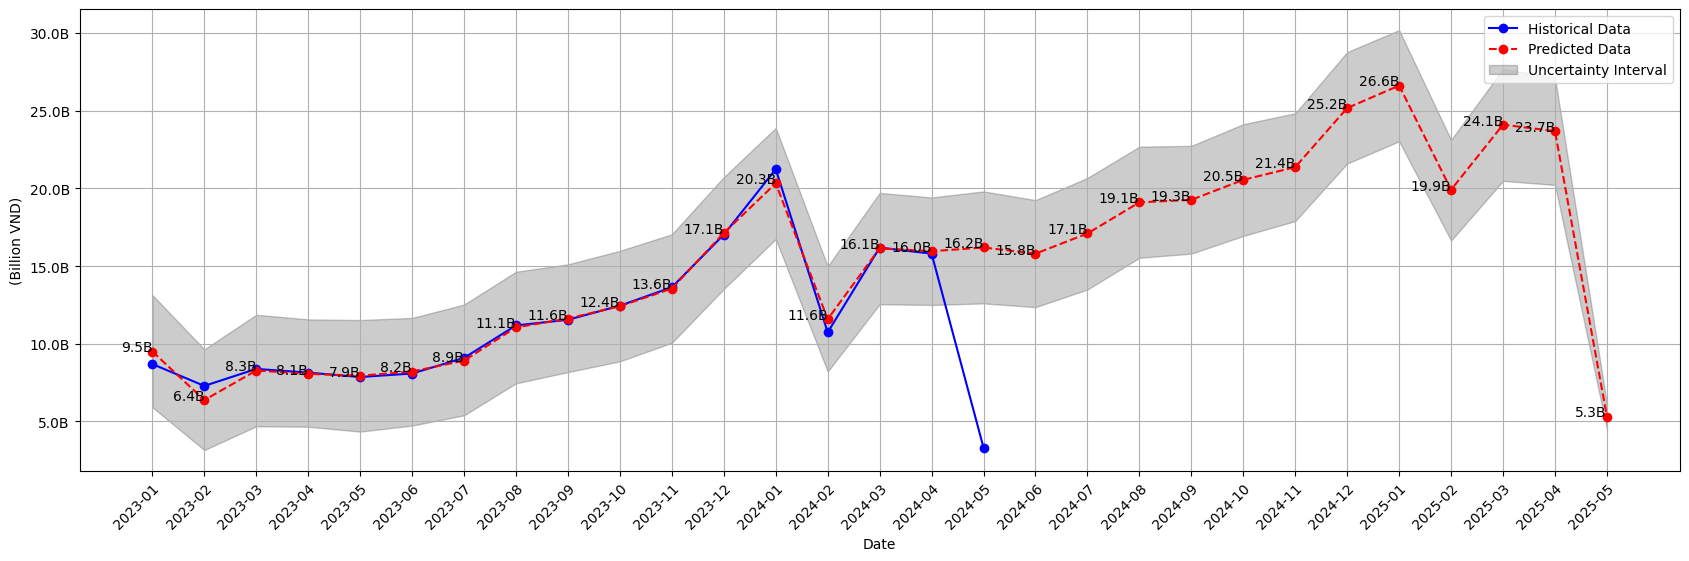

<Figure size 640x480 with 0 Axes>

In [16]:
df= forecast_gsv_bike_sgn.resample_and_plot_data(_df_forecast=df_forecast.copy(),start_date='2022-01-01')


### Export data
* call funtion export_data, provide dataframe, file type (excel or csv) and file name

In [17]:
# forecast_gsv_bike_sgn.export_data(df=df_forecast,file_name='gsv_bike_sgn',file_type='excel')
forecast_gsv_bike_sgn.export_data(df=df_forecast,file_name='gsv_truck_24',file_type='excel')

Export data sucessfully!
